In [1]:
class generateImages:
    #Generates satellite images to target specific addresses
    
    def __init__(self, root_path, center_lat, center_lon, imsize = 1024):
        """
        root_path: path of folder containing csv w/ image info and all images
        center_lat: center latitude of building at address
        center_lon: center longitude of building at address
        imsize: size of image in px
        """
        self.root_path         = root_path
        self.parent_image_path = 0
        self.center_lat        = center_lat
        self.center_lon        = center_lon
        self.imsize            = imsize
        self.projinfo          = "+proj=utm +zone=11S, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
        self.spatial_resolution = 0
        self.ul_x = 0
        self.ul_y = 0
        self.center_coords = 0
        
    def generate_image(self, classified = False):
        """
        Generates a georeferenced side_length x side_length RGB image from Google Earth around a center latitude and longitude
        classified: boolean denoting whether to return classified map (True: classified map, False: RGB) 
        """
        from PIL import Image
        import numpy as np
        
        #get image path and bounding box
        parent_image_path,bounding_box = self.find_parent_image()
        parent_image_path = classified*(parent_image_path.split('.')[0] + '_kclustering.tif') + parent_image_path*(not classified)
        self.parent_image_path = parent_image_path
        
        #open image
        image = Image.open(parent_image_path)
        
        #find pixel location of center_lat, center_lon
        center_coords = self.find_pixel_location(parent_image_path,bounding_box,image.size,self.center_lon,self.center_lat) #(x,y) coordinates of center pixel
        image = image.crop((center_coords[0] - self.imsize/2, center_coords[1] - self.imsize/2, center_coords[0] + self.imsize/2,center_coords[1] + self.imsize/2))
        self.center_coords = center_coords
        
        if classified:
            image = np.array(image)
            
        return image
                
    def find_parent_image(self):
        """
        Returns path of large georeferenced satellite image containing the desired location and a dictionary with 
        the upper left and lower right GPS bounding coordinates
        """
        #load master image info file and check bounds to find address of image w/ these coordinates
        #return path
        import glob, os
        os.chdir(self.root_path)

        ul_lat, ul_lon, lr_lat, lr_lon = [],[],[],[]
        contains_image = []
        files          = []
        for i,file in enumerate(glob.glob("*.dat")):
            with open(file, 'r') as f:
                line_num = 0
                for line in f:
                    line_num += 1
                    files.append(file)
                    if line_num == 2:
                        ul_lon.append(float(line.strip().split(',')[0]))
                        ul_lat.append(float(line.strip().split(',')[1])) 
                    elif line_num == 4:
                        lr_lon.append(float(line.strip().split(',')[0]))
                        lr_lat.append(float(line.strip().split(',')[1]))
            contains_image.append((self.center_lat < ul_lat[i]) and (self.center_lat > lr_lat[i]) and (self.center_lon > ul_lon[i]) and (self.center_lon < lr_lon[i]))
        
        #Return path of image that contains the coordinates or None if there is no such image
        if max(contains_image) == 0:
            print("Could not find parent images that contain the input coordinates. Please verify coordinates.")
            return None
        else:
            image_index = contains_image.index(max(contains_image))
            bounding_box = {'ul_lat':ul_lat[image_index],'ul_lon':ul_lon[image_index],'lr_lat':lr_lat[image_index],'lr_lon':lr_lon[image_index]}
            return self.root_path + files[image_index].split('.')[0] + '.jpg', bounding_box
    
    def verify_GPS_containment(self):
        """
        Searches folder that contains many images and returns the path of the parent image that contains the GPS coordinates
        """
        #return self.root_path + files[contains_image.index(max(contains_image))]
    
    def find_spatial_resolution(self, bounding_box, image_size):
        """
        parent_image_path: path of parent image
        bounding_box: dictionary containing lat, lon of upper left and lower right points in parent image
        image_size: tuple with image (width, height)
        Returns the pixel size of the parent image in m and UTM coordinates of upper left point
        Uses the image dimensions and bounding coordinates
        Does not currently account for projection
        """
        from pyproj import Proj
        
        myProj = Proj(self.projinfo)
        UTMx_ul, UTMy_ul = myProj(bounding_box['ul_lon'], bounding_box['ul_lat'])
        UTMx_lr, UTMy_lr = myProj(bounding_box['lr_lon'], bounding_box['lr_lat'])
        
        horizontal_scale = (UTMx_lr - UTMx_ul)/image_size[0]
        vertical_scale = (UTMx_lr - UTMx_ul)/image_size[0]
        
        self.spatial_resolution = vertical_scale
        self.ul_x               = UTMx_ul
        self.ul_y               = UTMy_ul
        
        return vertical_scale#, UTMx_ul, UTMy_ul
    
    def find_pixel_location(self,parent_image_path,bounding_box,image_size,lon,lat):
        """
        Returns (x,y) location of a lon, lat point within an image
        bounding_box: dictionary containing lat, lon of upper left and lower right points in parent images
        image_size: tuple with image (width, height)
        lon: longitude
        lat: latitude
        """
        #from pyproj import Proj
        
        resolution = self.find_spatial_resolution(bounding_box,image_size) #resolution of image in m
        #myProj = Proj(self.projinfo)
        #UTMx_point, UTMy_point = myProj(lon,lat) #UTM coordinates of point of interest

        #return (round(abs(UTMx_point-UTMx_ul)/resolution),round(abs(UTMy_point-UTMy_ul)/resolution))
        from osgeo import gdal

        driver = gdal.GetDriverByName('GTiff')
        dataset = gdal.Open(parent_image_path)
        band = dataset.GetRasterBand(1)

        cols = dataset.RasterXSize
        rows = dataset.RasterYSize

        transform = dataset.GetGeoTransform()

        xOrigin = transform[0]
        yOrigin = transform[3]
        pixelWidth = transform[1]
        pixelHeight = -transform[5]
        data = band.ReadAsArray(0, 0, cols, rows)
        points_list = [(lon , lat)] #list of X,Y coordinates
        for point in points_list:
            col = int((point[0] - xOrigin) / pixelWidth)
            row = int((yOrigin - point[1] ) / pixelHeight)
        
        return (col,row)
           

0 0 0 (10472, 4496)


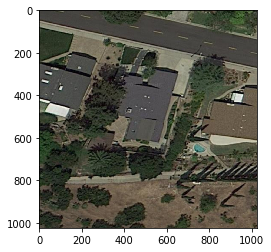

In [67]:
#import numpy as np
#import matplotlib.pyplot as plt
#x = generateImages('C:/Users/ntste/Documents/Insight/Tree Data/SAS Output/',34.276022,-118.292282)
#output=x.generate_image()
#print(x.spatial_resolution,x.ul_x,x.ul_y,x.center_coords)
#plt.imshow(output,cmap="PiYG")
#plt.show()
#imwrite(output,'C:/Users/ntste/Documents/Insight/Tree Data/SAS Output/test.jpg')